# Ejercicio 1 — Índices ENSO (ONI, SOI, Niño 3.4)

**Objetivo:** Familiarizarse con los índices que describen el ENSO y analizar las correlaciones cruzadas entre ellos.

**Contenido del notebook**
- Cargar/descargar series ONI, SOI y TSM Niño 3.4.
- Visualizar las series.
- Calcular correlaciones y correlaciones cruzadas con significancia.
- Interpretar resultados.



In [2]:
# Librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, stats
import os

# Opcional: instalar paquetes en Colab
# !pip install xarray netCDF4 cartopy eofs


In [3]:
# --- Opcional: descargar índices desde NOAA (requiere internet)
# ONI and NINO3.4 SST anomalies (example URL - revisar en caso de cambios en la web)
oni_url = "https://www.ncei.noaa.gov/access/monitoring/enso/sst/ONI.csv"
soi_url = "https://www.ncei.noaa.gov/access/monitoring/enso/soi/soi.csv"
# Ejemplo de cómo descargarlos (comentado para evitar errores si no hay internet)
# oni = pd.read_csv(oni_url)
# soi = pd.read_csv(soi_url)
# En la práctica, adaptar la lectura al formato exacto proporcionado por NOAA.


In [4]:
# Cargar dataset de ejemplo incluido en el repositorio
csv_path = "https://raw.githubusercontent.com/fbecker23/TP-Oceano---Circulacion-General/main/ejercicios/ejercicio-1/ejemplo_ONI_SOI.csv"
df = pd.read_csv(csv_path, parse_dates=['date'])
df.set_index('date', inplace=True)
df.head()


,ONI,SOI,NINO34
date,,,
2000-01-01,0.353,-0.417,0.372
2000-02-01,0.145,-0.188,0.090
2000-03-01,0.325,-0.423,0.340
2000-04-01,0.640,-0.857,0.706
2000-05-01,0.624,-0.463,0.589


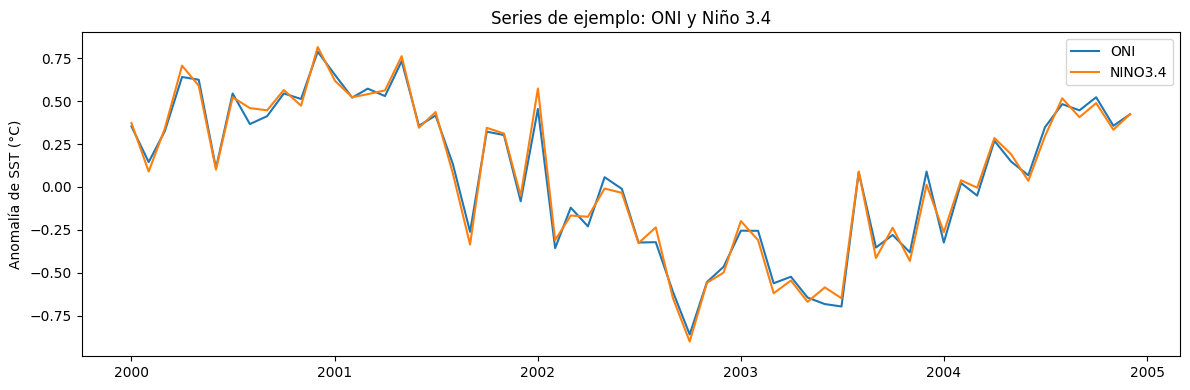

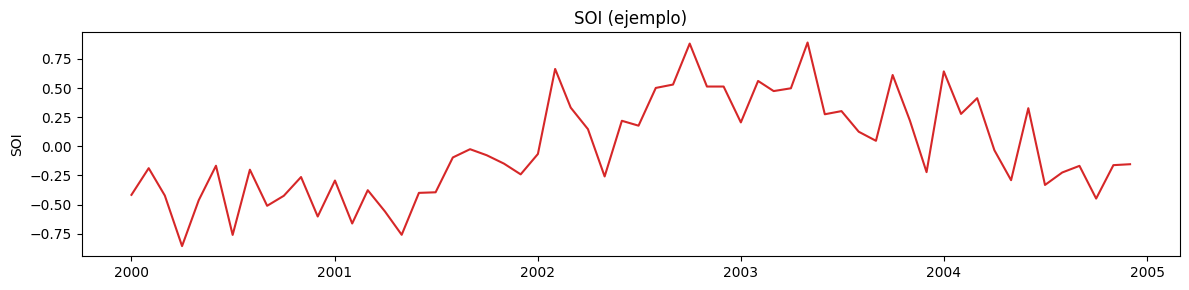

In [6]:
# Series temporales: ONI, SOI, NINO3.4
plt.figure(figsize=(12,4))
plt.plot(df.index, df['ONI'], label='ONI')
plt.plot(df.index, df['NINO34'], label='NINO3.4')
plt.ylabel('Anomalía de SST (°C)')
plt.legend()
plt.title('Series de ejemplo: ONI y Niño 3.4')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,3))
plt.plot(df.index, df['SOI'], color='C3', label='SOI')
plt.title('SOI (ejemplo)')
plt.ylabel('SOI')
plt.tight_layout()
plt.show()


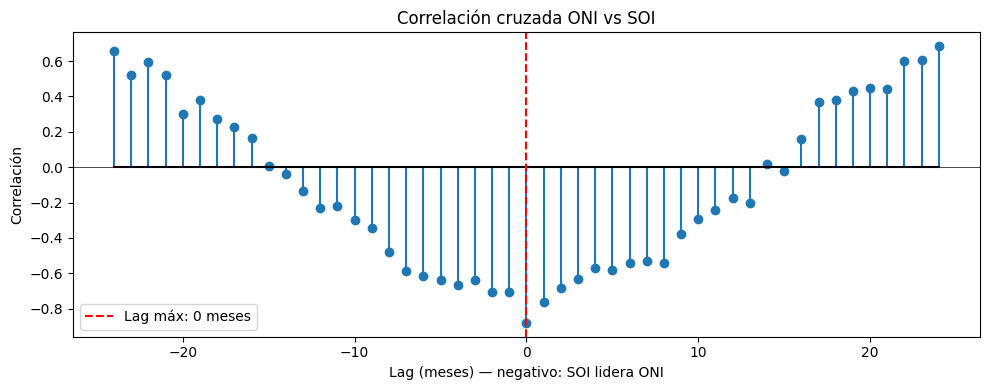

In [ ]:
# Función de correlación cruzada normalizada con lags
def cross_correlation(x, y, maxlag=24):
    x = np.array(x) - np.nanmean(x)
    y = np.array(y) - np.nanmean(y)
    x = x / np.nanstd(x)
    y = y / np.nanstd(y)
    n = len(x)
    lags = np.arange(-maxlag, maxlag+1)
    cc = []
    for lag in lags:
        if lag < 0:
            cc.append(np.corrcoef(x[:lag], y[-lag:])[0,1])
        elif lag > 0:
            cc.append(np.corrcoef(x[lag:], y[:-lag])[0,1])
        else:
            cc.append(np.corrcoef(x, y)[0,1])
    return lags, np.array(cc)

# calcular cross-correlation entre ONI y SOI
lags, cc_oni_soi = cross_correlation(df['ONI'].values, df['SOI'].values, maxlag=24)

# plot
fig, ax = plt.subplots(figsize=(10,4))
markerline, stemlines, baseline = ax.stem(lags, cc_oni_soi, basefmt="k-", linefmt="C0-", markerfmt="C0o")
plt.xlabel('Lag (meses) — negativo: SOI lidera ONI')
plt.ylabel('Correlación')
plt.title('Correlación cruzada ONI vs SOI')
plt.axhline(0, color='k', linewidth=0.5)
plt.tight_layout()
lag_max = lags[np.argmax(np.abs(cc_oni_soi))]
plt.axvline(lag_max, color='r', linestyle='--', label=f'Lag máx: {lag_max} meses')
plt.legend()
plt.show()


In [ ]:
# Estimación simple de significancia usando N_eff por autocorrelación lag-1
def effective_sample_size(x):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    n = len(x)
    if n < 3:
        return n
    rho1 = np.corrcoef(x[:-1], x[1:])[0,1]
    n_eff = n * (1 - rho1) / (1 + rho1)
    return max(1, n_eff)

n_eff = effective_sample_size(df['ONI'].values)
print(f"Effective sample size (ONI example): {n_eff:.1f}")

# Critical correlation for alpha=0.05 (two-sided)
alpha = 0.05
crit = stats.t.ppf(1-alpha/2, df=n_eff-2)
# convert t to r: r = t/sqrt(t^2 + df)
r_crit = crit / np.sqrt(crit**2 + (n_eff - 2))
print(f"Critical r (alpha=0.05) approx: {r_crit:.3f}")


Effective sample size (ONI example): 7.6
Critical r (alpha=0.05) approx: 0.723


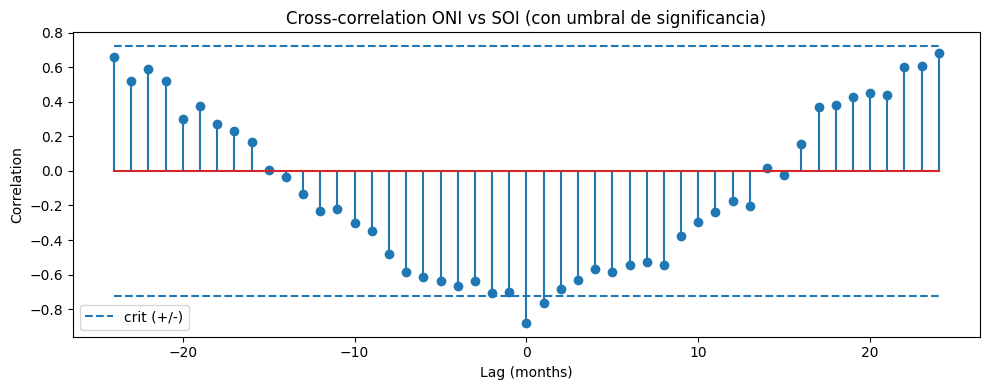

In [ ]:
# Plot with significance threshold
plt.figure(figsize=(10,4))
plt.stem(lags, cc_oni_soi)
plt.hlines(y=r_crit, xmin=lags.min(), xmax=lags.max(), linestyles='dashed', label='crit (+/-)')
plt.hlines(y=-r_crit, xmin=lags.min(), xmax=lags.max(), linestyles='dashed')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation')
plt.title('Cross-correlation ONI vs SOI (con umbral de significancia)')
plt.legend()
plt.tight_layout()
plt.show()


## Guía de interpretación

- Valores de correlación cercanos a 1 o -1 indican fuerte relación lineal.
- El signo indica fase (positiva -> mismas fases; negativa -> fases opuestas).
- Lags positivos indican que la primera serie **(ONI)** lidera a la segunda.
- Evaluar significancia usando N_eff para evitar el efecto de la autocorrelación.
- Actividad adicional: calcular correlaciones móviles (ventana de 5-10 años) para estudiar estabilidad temporal de la relación.
